In [ ]:
# !pip install PyNomaly
# !pip install opencv-python
# !pip install pyod
# !pip install anomalib

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data, evaluate_print
from pyod.utils.example import visualize

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score

from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")

## 2. Isolation Forest

In [ ]:
df = pd.read_csv(r'C:\Users\Admin\Anamoly Detection\Battery_RUL.csv')
df

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


In [ ]:
df.drop(['Cycle_Index','RUL'],axis = 1,inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Discharge Time (s)         15064 non-null  float64
 1   Decrement 3.6-3.4V (s)     15064 non-null  float64
 2   Max. Voltage Dischar. (V)  15064 non-null  float64
 3   Min. Voltage Charg. (V)    15064 non-null  float64
 4   Time at 4.15V (s)          15064 non-null  float64
 5   Time constant current (s)  15064 non-null  float64
 6   Charging time (s)          15064 non-null  float64
dtypes: float64(7)
memory usage: 823.9 KB


In [ ]:
#Define objective function for unsupervised LOF
def objective(model,X_train):
    model.fit(X_train)
    anomaly_scores = model.decision_function(X_train)

    #Analyze IQR of anomaly scores
    iqr = np.quantile(anomaly_scores, 0.75) - np.quantile(anomaly_scores,0.25)
    anomalies = anomaly_scores > np.quantile(anomaly_scores,0.75) + 1.5 * iqr

    # Use appropriate metric for your anomaly detection task (e.g., precision, recall, F1 score)
    metric = precision_score(np.zeros_like(anomaly_scores), anomalies)
    return metric

def hyperparameter_tuning_iforest(df):
    param_space = {
        "contamination": [0.1, 0.2,0.3,0.4,0.5],
        "n_estimators": range(500, 1200),
        "max_samples": [100,300,500,700,900,1100,1300]
    }
    # Perform random search
    random_search = RandomizedSearchCV(IForest(), param_space, scoring=objective, n_iter=100, cv=5)
    random_search.fit(df)
    return random_search.best_params_

def iforest_model(X, best_param):
    model =  IForest(n_estimators=best_param['n_estimators'], random_state=42,contamination = best_param['contamination'], max_samples = best_param['max_samples'] )
    model.fit(X)
    anomaly_scores = model.decision_function(X)
    threshold = model.threshold_
    return anomaly_scores, threshold

def iqr_outlier_remove(anomaly_scores):
    q1, q3 = np.percentile(anomaly_scores, [25, 75])
    iqr = q3 - q1
    threshold_low = q1 - 1.5 * iqr
    threshold_high = q3 + 1.5 * iqr
    anomalies = (anomaly_scores < threshold_low) | (anomaly_scores > threshold_high)
    return anomalies

def visualization_plot(anomaly_scores, column_name,clean_data):
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    fig.suptitle(f'Outlier handling for the feature {column_name}')

    axes[0].set_title(f'Anomoly Score Plot ')
    axes[0].scatter(range(len(anomaly_scores)), anomaly_scores,c=anomaly_scores, cmap='coolwarm', s=30, label='Anomaly Score')
    # Before removing outliers plot
    axes[1].set_title(f'Before Removing Outliers')
    axes[1].scatter(range(len(df[column_name])), df[column_name], c=anomaly_scores, cmap='coolwarm', s=30, label='Anomaly Score')

    axes[2].scatter(np.arange(len(clean_data)), clean_data, alpha = 0.5)
    axes[2].set_title(f'After Removing Outliers')
    plt.tight_layout()
    plt.show()

    return None


### Removing outlier based on inbuild thrshold provided by iforest

In [ ]:
best_params = hyperparameter_tuning_iforest(df)
print("Best Params:", best_params)

In [ ]:
def anomoly_detection_iforest(X, column_name, best_params):
    X = X.to_numpy()
    anomaly_scores, threshold = iforest_model(X, best_params)
    #Setting threshold value
    #threshold = 0.35
    outlier = np.where(anomaly_scores > threshold)[0]
    data_no_outlier = np.delete(df[column_name].to_numpy(), outlier)
    visualization_plot(anomaly_scores, column_name,data_no_outlier)
    return None


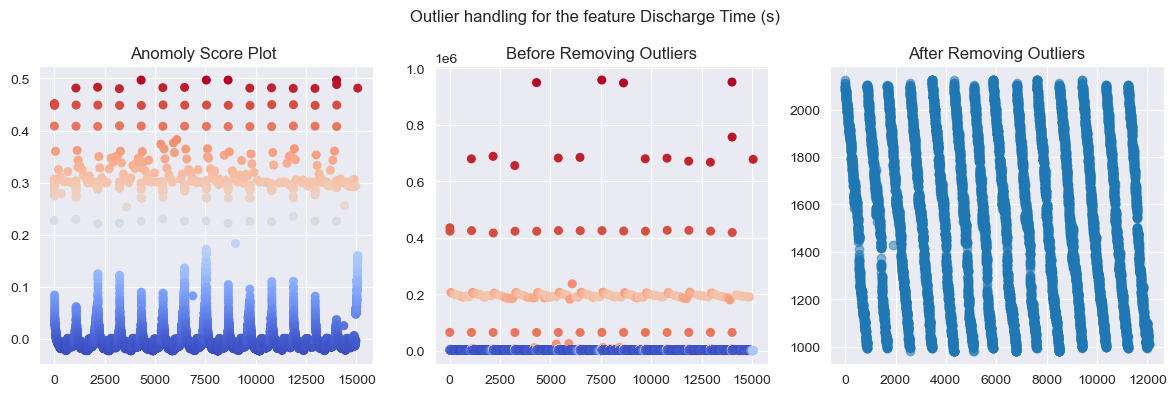

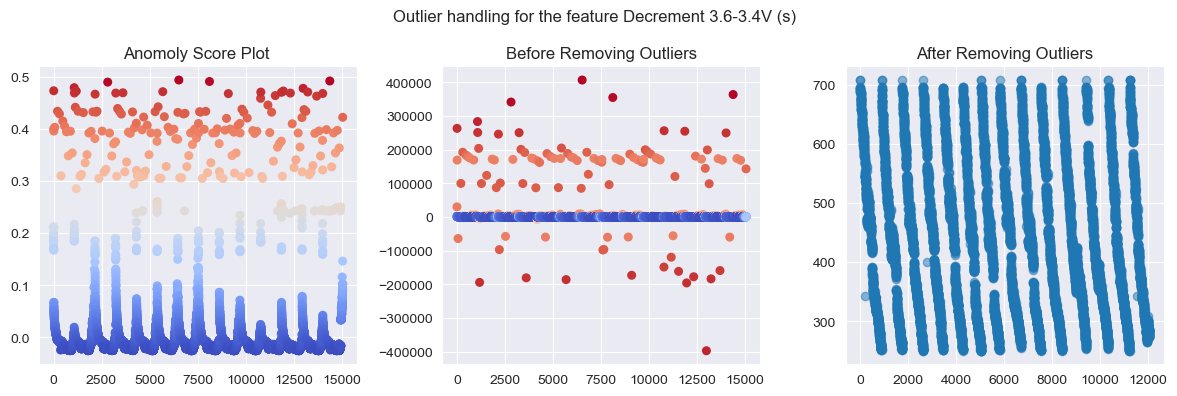

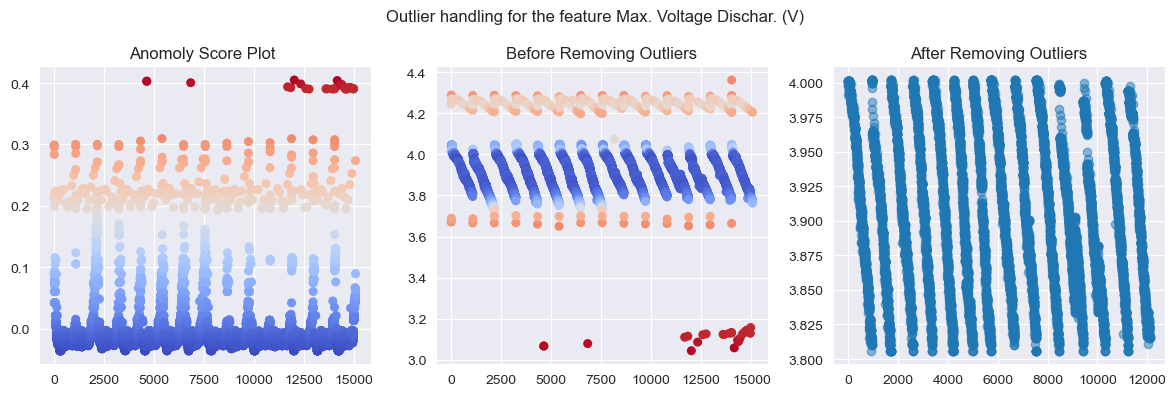

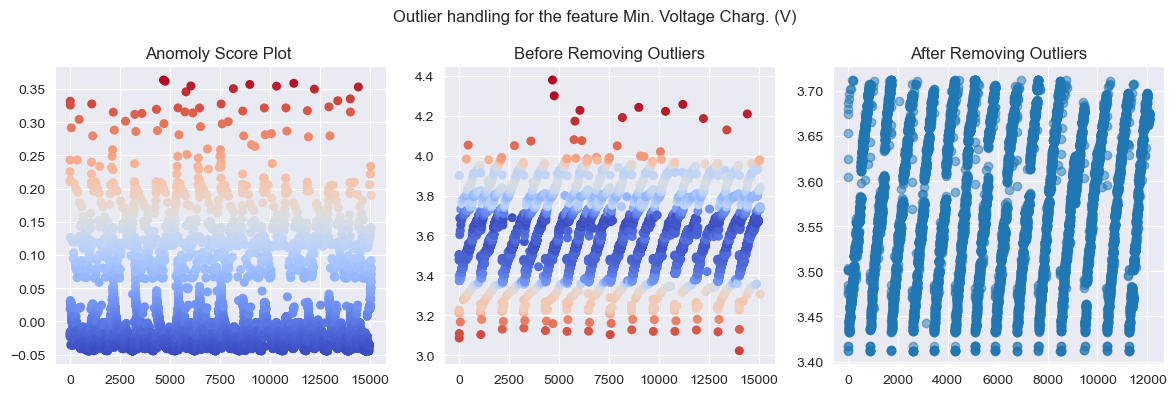

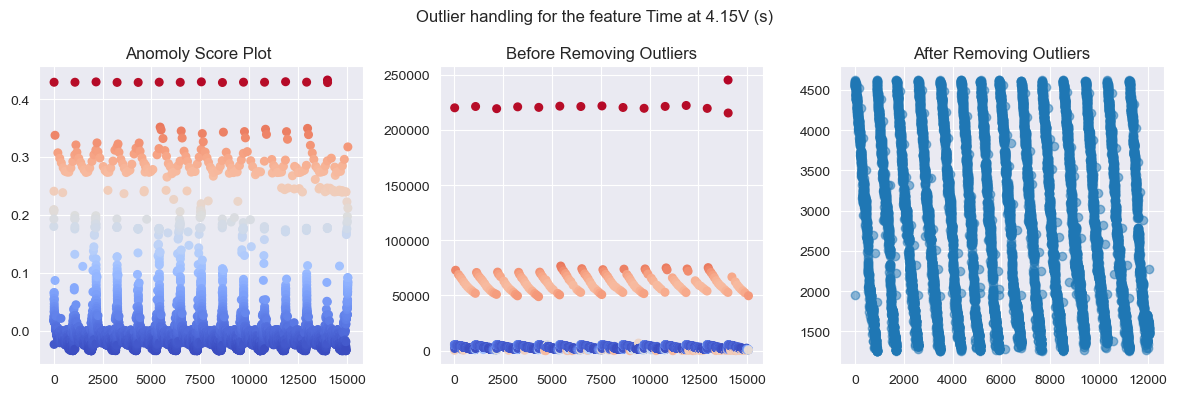

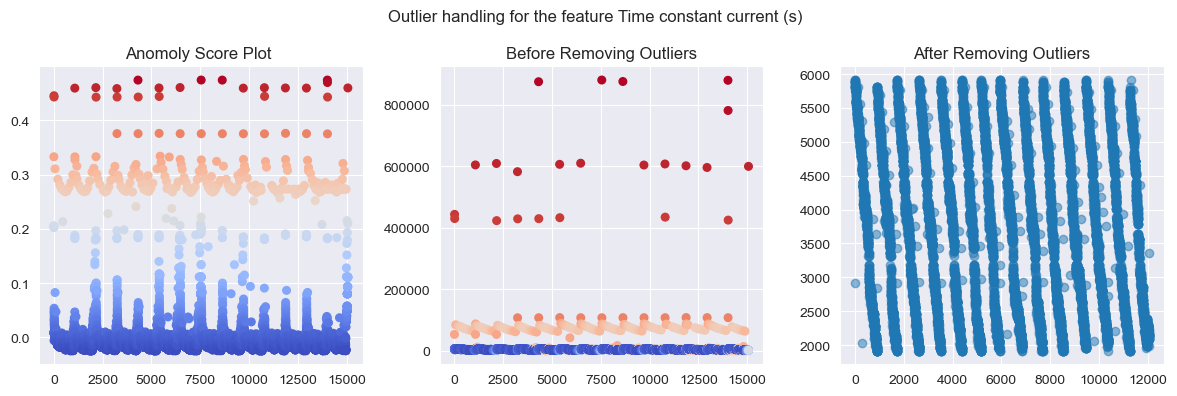

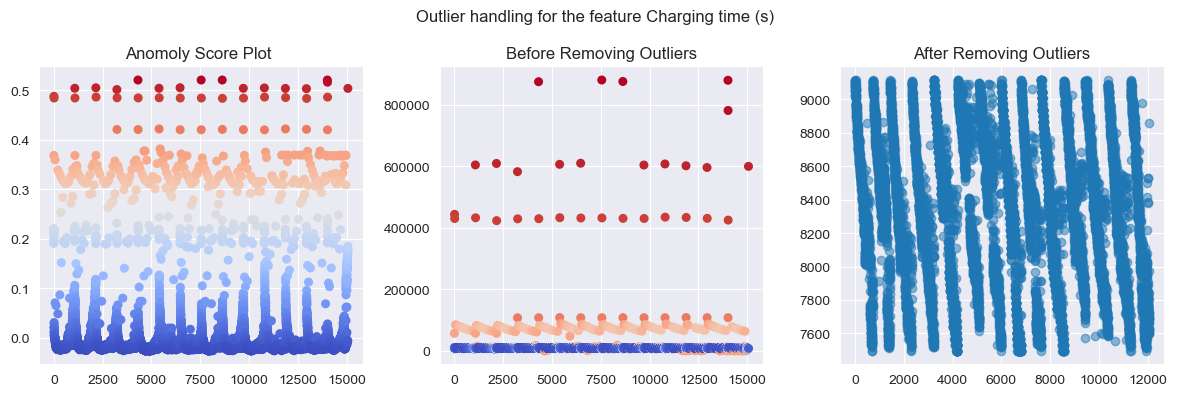

In [ ]:
best_params =  {'n_estimators': 926, 'max_samples': 1300, 'contamination': 0.2}
for col_name in df.columns:
    anomoly_detection_iforest(df[[col_name]],col_name,best_params)
    print('\n')


## Removing Outlier by using IQR Technique

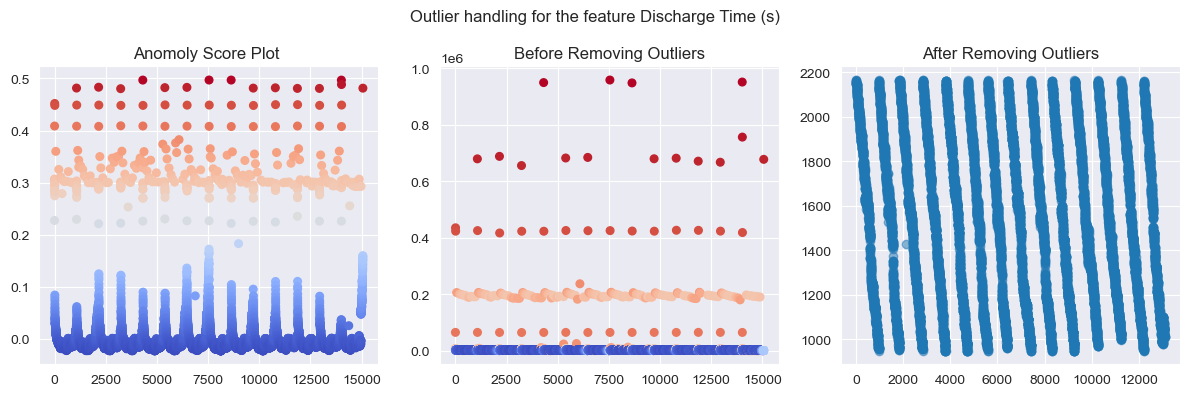

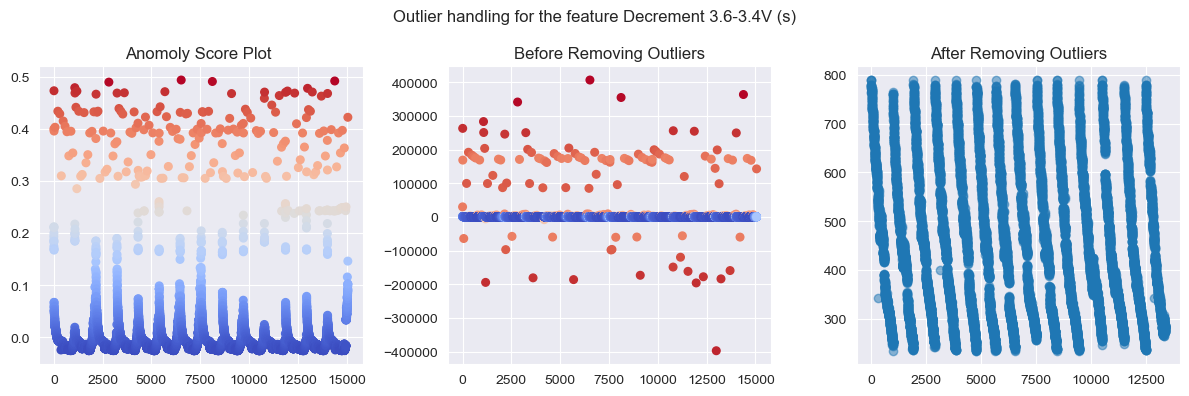

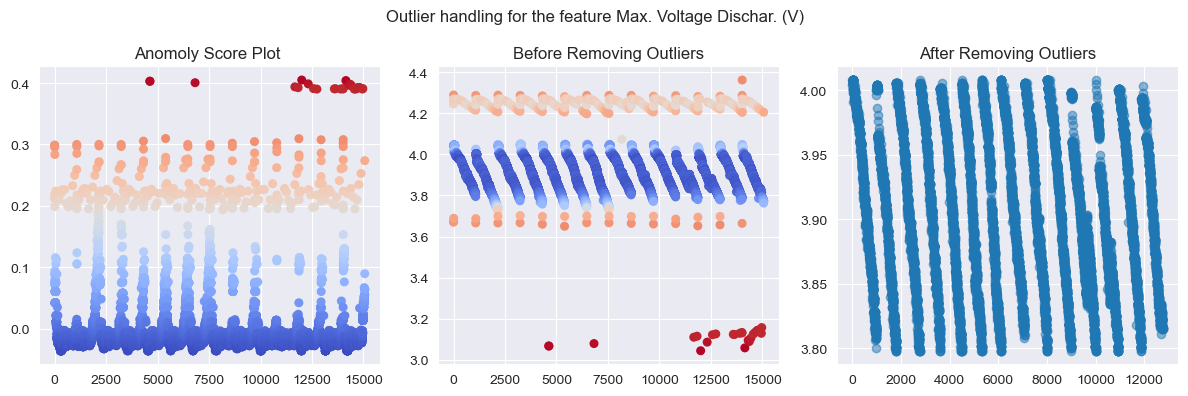

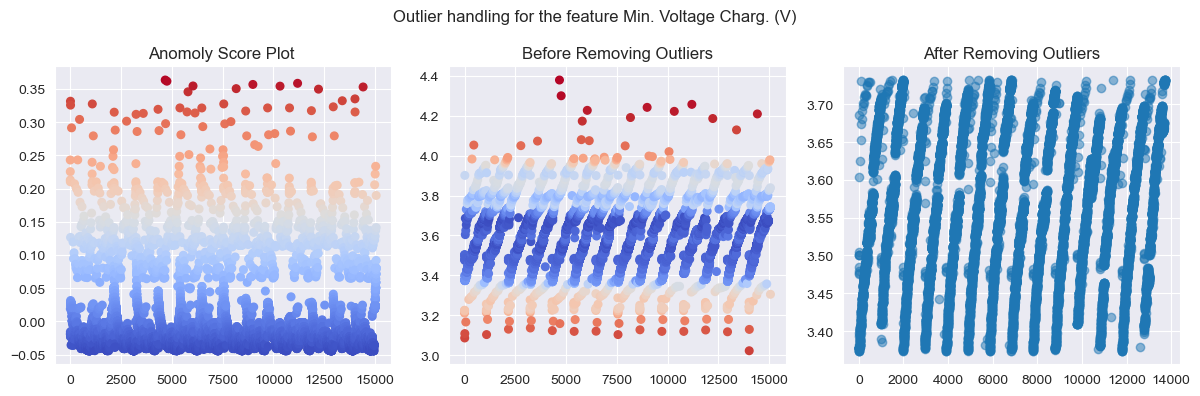

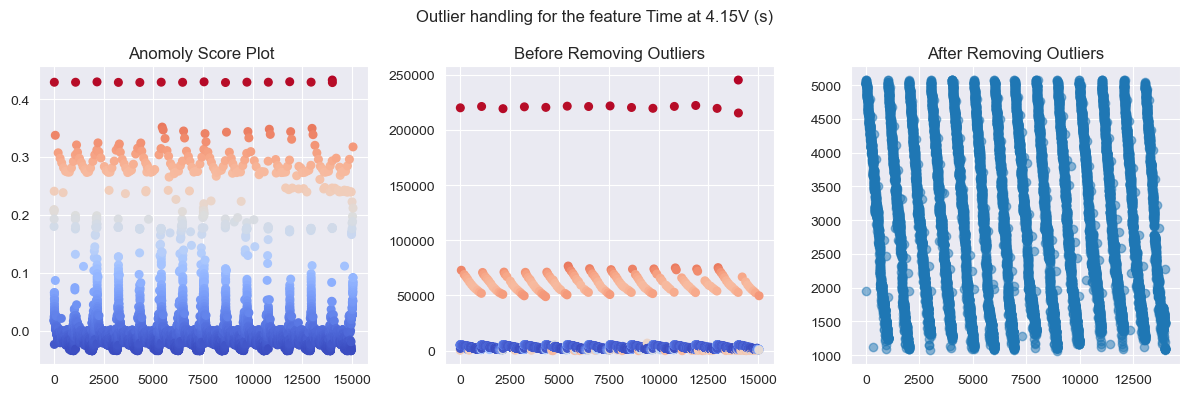

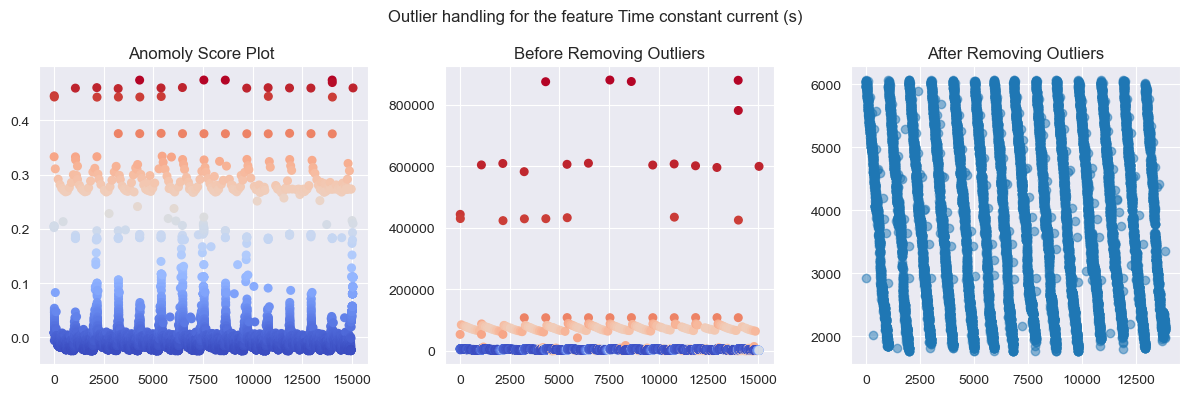

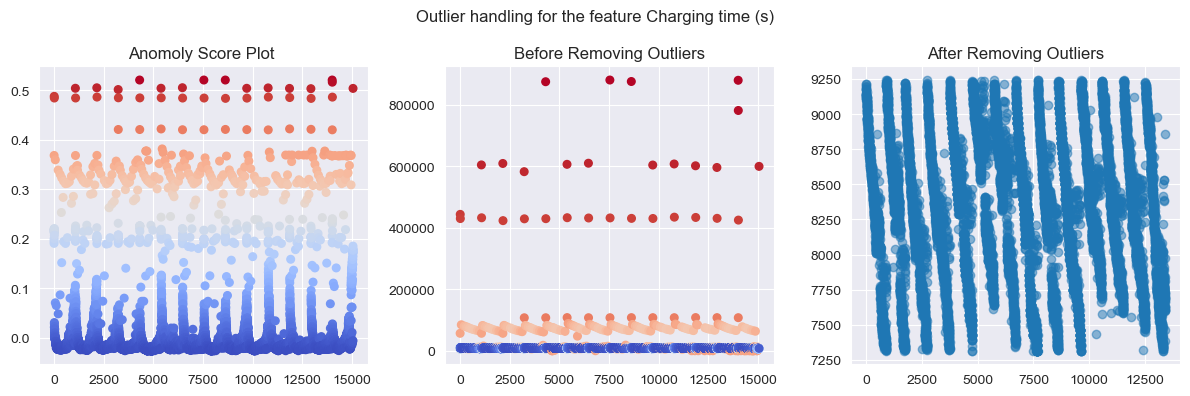

In [ ]:
def anomoly_detection_iforest(X, column_name,best_params):
    X = X.to_numpy()
    anomaly_scores, threshold = iforest_model(X, best_params)
    anomalies = iqr_outlier_remove(anomaly_scores)
    clean_data = X[~anomalies]
    visualization_plot(anomaly_scores, column_name,clean_data)
    return None


for col_name in df.columns:
    anomoly_detection_iforest(df[[col_name]],col_name,best_params)
    print('\n')
